Load some standard libraries

In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything
from xgboost import XGBRegressor

seed_everything(42);

/Users/sophie/opt/anaconda3/envs/space-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


We will use the following libraties from spacebench.

In [2]:
from spacebench import (
    SpaceEnv,
    SpaceDataset,
    DataMaster,
    DatasetEvaluator,
    EnvEvaluator,
    algorithms
)
from spacebench.algorithms import spatialplus
from spacebench.algorithms import spatial


Load the datamaster to list available datasets

In [3]:
DataMaster().list_datasets()

['spacec_elect_cs_ed_above_college_election_dem_pct']

Create the environment.

In [4]:
envname = "spacec_elect_cs_ed_above_college_election_dem_pct"
env = SpaceEnv(envname)
env.__dict__.keys()

dict_keys(['name', 'datamaster', 'api', 'dir', 'config', 'synthetic_data', 'metadata', 'graph', 'confounding_score_dict', 'smoothness_score_dict'])

Example of generating a dataset.

In [5]:
dataset = env.make()
print("treatment shape", dataset.treatment.shape)
print("covariates shape", dataset.covariates.shape)
print("num. edges", len(dataset.edges)) 
print("smoothness of missing confounder", dataset.smoothness_of_missing)
print("confounding of missing confounder", dataset.confounding_of_missing)


treatment shape (2821,)
covariates shape (2821, 44)
num. edges 8263
smoothness of missing confounder 0.9449527206623363
confounding of missing confounder 0.06880235416329153


We can loop over all possible datasets using the make_all method.

Text(0.5, 0.98, 'Distribution of confounding and smoothness')

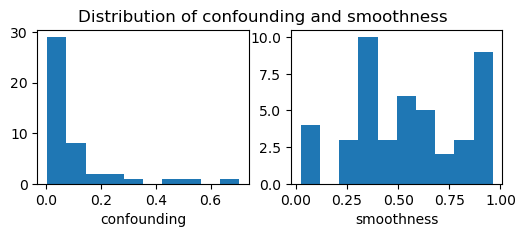

In [6]:
confounding_scores = []
smoothness_scores = []
for dataset in env.make_all():
    confounding_scores.append(dataset.confounding_of_missing)
    smoothness_scores.append(dataset.smoothness_of_missing)

fig, ax = plt.subplots(1, 2, figsize=(6, 2))
ax[0].hist(confounding_scores)
ax[0].set_xlabel("confounding")
ax[1].hist(smoothness_scores)
ax[1].set_xlabel("smoothness")
plt.suptitle("Distribution of confounding and smoothness")

Let's now illustrate how to use the evaluator. On **one** dataset.
We will compare two methods. These methods are not real competitive spatial confounding 
methods, but they are easy to implement and illustrate the use of the evaluator.

One model is a simple xgboost regression model without any type of spatial confounding correction.
The other model uses the coordinates (lon/lats) as features in the model.

In [7]:
def estimate_counterfactuals(model, dataset: SpaceDataset):
    """Helper function to fit a model and predict counterfactuals.
    
    Arguments
    ---------
    model: spatial or spatialplus
        A model with a fit method.
    dataset: SpaceDataset
        A SpaceDataset object.
        
    Returns
    -------
    counterfactuals: np.ndarray
        A n x m matrix of counterfactuals, where n is the number of units and m is the number of treatment values.
    """
    treatment = dataset.treatment[:, None]
    covariates = dataset.covariates
    outcome = dataset.outcome
    coords = np.array(dataset.coordinates)
    covnames = ['cov' + str(i+1) for i in range(covariates.shape[1])]
    df = pd.DataFrame(np.column_stack((coords, covariates, treatment, outcome)), 
                    columns=['coord1', 'coord2'] + covnames + ['X', 'Y'])
    if model == spatialplus:
        fit_bs_x, fit_bs_y = model.fit(treatment, outcome, coords, df, binary_treatment=False)
        print(fit_bs_x.summary())
        print(fit_bs_y.summary())
        dfpred_x = pd.DataFrame(dataset.covariates,
                        columns= covnames)
        xpred = fit_bs_x.predict(dfpred_x, coords)
    if model == spatial:
        fit_bs_y = model.fit(treatment, outcome, coords, df)
        print(fit_bs_y.summary())

    tvals = dataset.treatment_values
    counterfactuals = []
    for tval in tvals:
        if model == spatialplus:
            dfpred_y = pd.DataFrame(np.column_stack((dataset.covariates, np.full_like(dataset.treatment[:, None], tval)-xpred.values.reshape(-1,1))), 
                        columns= covnames + ['r_X'])
        if model == spatial:
            dfpred_y = pd.DataFrame(np.column_stack((dataset.covariates, np.full_like(dataset.treatment[:, None], tval))), 
                        columns= covnames + ['X'])
        counterfactuals.append(fit_bs_y.predict(dfpred_y, coords))
    counterfactuals = np.stack(counterfactuals, axis=1)

    return counterfactuals


Now use the `DatasetEvaluator` class.

Let us know loop over all datasets and compare the two models. The `EnvEvaluator` evalautor is designed for this task. But we need an evaluator for each model.

We may sometimes prefer to use the dataset evaluator and keep metrics in each loop for a more detailed analysis.

In [8]:
# for each masked variable
smoothness_scores = []
confounding_scores = []
erf_error_spatial = []
erf_error_spatialplus = []

for dataset in tqdm(env.make_all()):
    evaluator = DatasetEvaluator(dataset)

    cfs_spatial = estimate_counterfactuals(spatial, dataset)
    erf_spatial = cfs_spatial.mean(0)
    cfs_spatialplus = estimate_counterfactuals(spatialplus, dataset)
    erf_spatialplus = cfs_spatialplus.mean(0)

    err_spatial = evaluator.eval(erf=erf_spatial)
    err_spatialplus = evaluator.eval(erf=erf_spatialplus)

    erf_error_spatial.append(np.square(err_spatial["erf_error"]).mean())
    erf_error_spatialplus.append(np.square(err_spatialplus["erf_error"]).mean())

    smoothness_scores.append(dataset.smoothness_of_missing)
    confounding_scores.append(dataset.confounding_of_missing)

/Users/sophie/opt/anaconda3/envs/space-env/lib/python3.10/site-packages/statsmodels/gam/generalized_additive_model.py:425: RuntimeWarning: invalid value encountered in sqrt
  wexog = np.sqrt(weights)[:, None] * self.model.exog


KeyboardInterrupt: 

In [ ]:
erf_errors = dict(
    smoothness=["low" if x < 0.5 else "high" for x in smoothness_scores],
    confounding=["low" if x < 0.1 else "high" for x in confounding_scores],
    spatial=erf_error_spatial,
    spatialplus=erf_error_spatialplus,
)
erf_errors = pd.DataFrame(erf_errors)
erf_errors.groupby(["smoothness", "confounding"]).agg(["mean", "std"])

We can see that adding coordinates gives worse results when smoothnes is low. Both models do a bit betteror about the same when confounding is low.